# Qaintellect Quantum Approximation Optimization Algorithm (QAOA)

In this example, we implement the optimization of a circuit based on a proposed QAOA algorithm by Farhi et al. [1] demonstrated via the solving of a Max-Cut problem.

In [1]:
include("../src/Qaintellect.jl")
using .Qaintellect
using Qaintessent, Flux, LinearAlgebra, Test
using Flux.Optimise: update!
using IterTools: ncycle
using StatsPlots

## Task: Max-Cut Problem
Given an arbitrary graph with $n$ vertices $V$ and $m$ edges, the goal of the Max-Cut problem is to partition the vertices into two sets, $S_{0}$ and $S_{1}$, such that the number of edges between the two sets is maximized. One example of a simple graph with 4 vertices demonstrating a Max-Cut solution is seen in the following Figure.


<div>
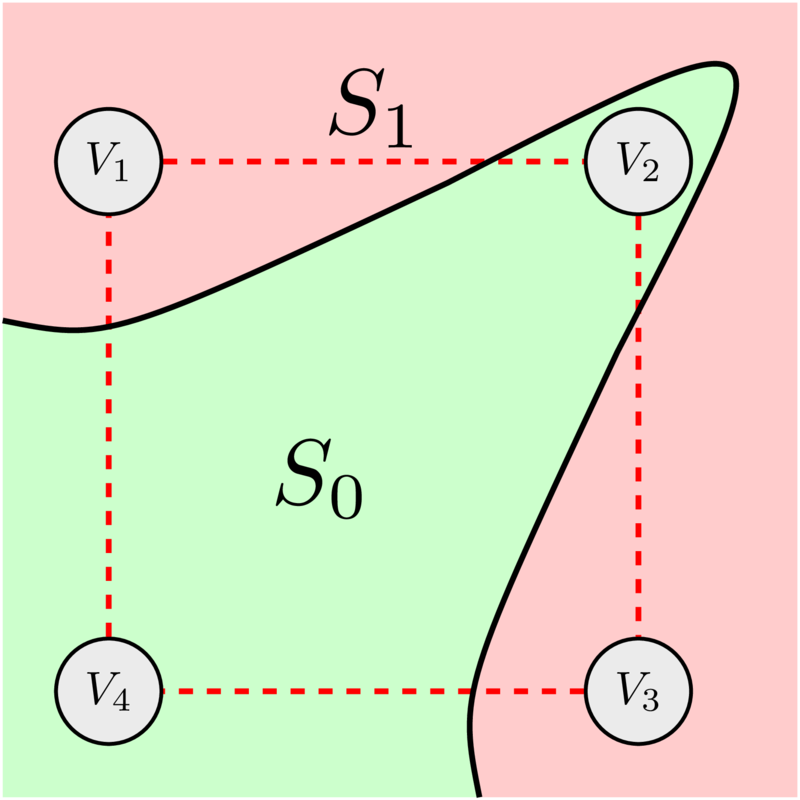
</div>


The Max-Cut problem can be interpreted as a combinatorial optimization problem with the goal of maximizing an objective function. The first step is to encode the problem as a series of $n$ bits, such that we can represent this encoding with a bitstring $z = z_{1}z_{2}...z_{n}$. The objective function $C$ can then be written as:

\begin{equation}
C(z) = \sum_{\alpha=1}^{m}{C_{\alpha}(z)}
\end{equation}

where each $C_{\alpha}$ represents a constraint, known as a clause, on a subset of bits in $z$. If we arbitrarily encode the problem such that vertices in set $S_{0}$ correspond to state 0 and vertices in set $S_{1}$ correspond to state 1, the solution presented in the diagram corresponds to bitstring $z = 1010$, where bit $z_{i}$ corresponds to vertex $V_{i}$. 

Note that the bitstring $z = 0101$ is equivalent to $z = 1010$ and depends on the arbitrary encoding chosen.

## Constructing the Quantum Circuit
Now that we have described the problem, we can then construct a quantum circuit to simulate this problem. We define the clauses in this problem as:

\begin{equation}
C_{\alpha} = \frac{1}{2} \left( -\sigma^{z}_{j} \sigma^{z}_{k} + 1 \right),
\end{equation}
where edge $\alpha$ joins vertices $V_{j}$ and $V_{k}$.

We define a set of parametrized unitary operators that allow us to explore the $2^{n}$ dimensional Hilbert space:

\begin{equation}
U_{C} = U(C, \gamma) = e^{-i \gamma C} = \prod_{\alpha=1}^{m}{e^{-i \gamma C_{\alpha}}},\\
U_{B} = U(B, \beta) = e^{-i \beta B} = \prod_{j=1}^{n}{e^{-i \beta \sigma^{x}_{j}}}, \; B = \sum_{j=1}^{n}{\sigma^{x}_{j}},\\
\end{equation}

starting from the uniform superposition state:

\begin{equation}
\lvert s \rangle = \frac{1}{\sqrt{2^{n}}} \sum_{z \in (0,1)^{n}}{\lvert z \rangle}.
\end{equation}

We choose a number of layers $ p \ge 1$ such that

\begin{equation}
\lvert \boldsymbol{\gamma}, \boldsymbol{\beta} \rangle = U_{B_{1}}U_{C_{1}}U_{B_{2}}U_{C_{2}}...U_{B_{p}}U_{C_{p}} \lvert s \rangle,
\end{equation}

which correspond to $2p$ angle parameters $\boldsymbol{\gamma} = \gamma_{1}\gamma_{2}...\gamma_{p}$ and $\boldsymbol{\beta} = \beta_{1}\beta_{2}...\beta_{p}$.

We can build the unitary operators $U_{C}$ and $U_{B}$ as follows

$\; \; \;\; \; \;\; \; \; \; U_{C} = e^{-i \gamma \left( -\sigma^{z}_{j} \sigma^{z}_{k} + 1 \right)} \;\; \; \;\;  \; \;\; \; \; \; \; \;\; \; \;\; \; \;\; \; \; \; \; \; \;U_{B} = e^{-i \beta \sigma^{x}_{j}}$

    j ——•———————————•———             j ———————[Rx]———————
        |           |   
    k —[X ]——[Rz]——[X ]—



    

In [2]:
# number of layers p
p = 1
# construct parametrized circuit, N is the number of vertices
N = 4
edges = [(1, 2), (2, 3), (3, 4), (4, 1)]

function circuit(p::Int, N::Int)
    gates = AbstractCircuitGate{N}[]
    for layer in 1:p
        for edge in edges
            push!(gates, controlled_circuit_gate(edge[1], edge[2], XGate(), N))
            push!(gates, single_qubit_circuit_gate(edge[2], RzGate(0.01*randn(Float64, 1)...), N))
            push!(gates, controlled_circuit_gate(edge[1], edge[2], XGate(), N))
        end

        for wire in 1:N
           push!(gates, single_qubit_circuit_gate(wire, RxGate(0.01*randn(Float64, 1)...), N))
        end
    end
    return gates
end

gates = circuit(p, N)
cgc1 = CircuitGateChain{N}(gates)

# Create measurement operators corresponding to clauses
meas_gates = Matrix[]
for edge in edges
    k1 = single_qubit_circuit_gate(edge[1], ZGate(), N)
    k2 = single_qubit_circuit_gate(edge[2], ZGate(), N)
    meas_op = CircuitGateChain{N}([k1, k2])
    push!(meas_gates, Qaintessent.matrix(meas_op))
end
meas = MeasurementOps{N}(meas_gates)

c1 = Circuit(cgc1, meas)


    1 ——•———————————•————————————————————————————————————————[X ]——[Rz]——[X ]——[Rx]—
        |           |                                         |           |         
    2 —[X ]——[Rz]——[X ]———•———————————•————————————————————————————————————————[Rx]—
                          |           |                       |           |         
    3 ———————————————————[X ]——[Rz]——[X ]———•———————————•——————————————————————[Rx]—
                                            |           |     |           |         
    4 —————————————————————————————————————[X ]——[Rz]——[X ]———•———————————•————[Rx]—


In [3]:
# Define objective function
function loss_function(ψ)
    loss = 0
    for ψi in ψ
        loss += 0.5 * (1 - ψi)
    end
    return loss
end

# Define uniform superposition state s
ψ = fill(1/√(2^N) + im*0.0, 2^N)

# Define expectation value. This is a known solution for our problem.
e = 4

# set up model
model(ψ) = loss_function(c1(ψ))

# create loss function
loss(x,y) = Flux.mse(model(x), y)

# gather parameters from Circuit
paras = Flux.params(c1)

# set up data for training
data = ncycle([(ψ, e)], 500)

# define optimizer
opt = Descent(0.4)

# define evaluation function
evalcb() = @show(loss(ψ, e))

println("Initial model evaluation: " * string(model(ψ)) * ", Target: " * string(e))

Flux.train!(loss, paras, data, opt, cb=Flux.throttle(evalcb, 0.5))

println("Final model evaluation: " * string(model(ψ)) * ", Target: " * string(e))

Initial model evaluation: 1.9999318529684305, Target: 4
loss(ψ, e) = 3.9986601429273474
loss(ψ, e) = 0.9999999999999991
loss(ψ, e) = 1.0
loss(ψ, e) = 1.0
Final model evaluation: 3.0, Target: 4


We see from the final loss $\approx 1$ that a single layer is insufficient to minimize the loss function. We can then plot the probability distribution of the trained Circuit.

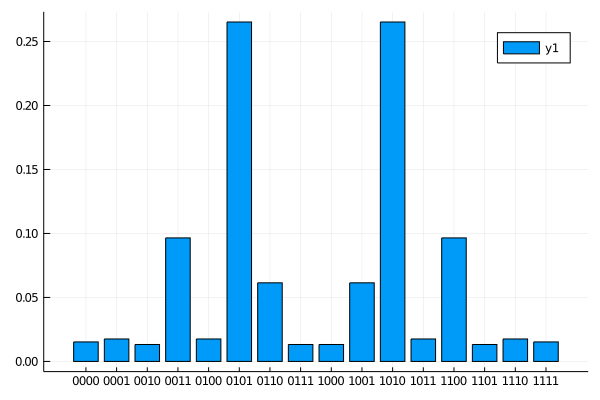

In [4]:
r = 0:2^N-1
tags = [join(reverse(digits(i, pad=N, base=2))) for i in r]
ψ1 = apply(c1.cgc,ψ)
ψ1 = norm.(ψ1) .* norm.(ψ1)

bar(tags, ψ1, xticks= :all, legend=false)

Note that the two correct solutions, $z=0101$ and $z=1010$ occur with the highest probability but there are other non-zero possibilities. So, in order to improve the accuracy of the circuit, we can increase the number of layers to 2. 

In [5]:
# Increase number of layers to p = 2
p = 2

gates = circuit(p, N)
cgc2 = CircuitGateChain{N}(gates)
c2 = Circuit(cgc2, meas)

# Define uniform superposition state s
ψ = fill(1/√(2^N) + im*0.0, 2^N)

# set up model
model(ψ) = loss_function(c2(ψ))

# create loss function
loss(x,y) = Flux.mse(model(x), y)

# gather parameters from Circuit
paras = Flux.params(c2)

# set up data for training
data = ncycle([(ψ, e)], 500)

# define optimizer
opt = Descent(0.4)

println("Initial model evaluation: " * string(model(ψ)) * ", Target: " * string(e))

Flux.train!(loss, paras, data, opt, cb=Flux.throttle(evalcb, 0.8))

println("Final model evaluation: " * string(model(ψ)) * ", Target: " * string(e))

Initial model evaluation: 1.9999069742368776, Target: 4
loss(ψ, e) = 3.9957743639120786
loss(ψ, e) = 6.737337752569383e-5
loss(ψ, e) = 1.9316106533535113e-5
loss(ψ, e) = 9.02268154118851e-6
loss(ψ, e) = 4.903520477443418e-6
Final model evaluation: 3.9981405308858946, Target: 4


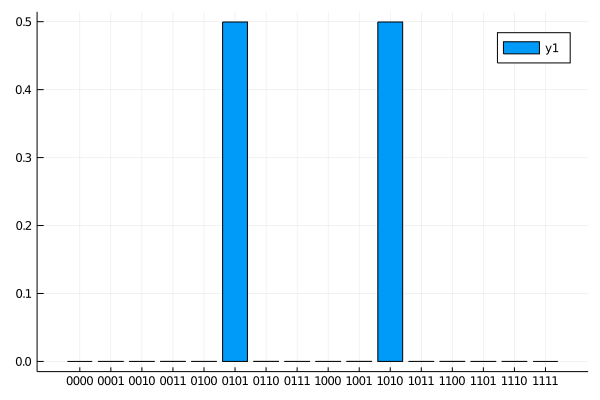

In [6]:
ψ2 = apply(c2.cgc, ψ)
ψ2 = norm.(ψ2) .* norm.(ψ2)

bar(tags, ψ2, xticks = :all, legend=false)

With a larger $p$, we see that the probbaility of either of the two solutions occuring tends to $50\%$.

[1] E. Farhi, J. Goldstone, and S. Gutmann, “A Quantum Approximate Optimization Algorithm,” pp. 1–16, 2014, [Online]. Available: http://arxiv.org/abs/1411.4028.